# Target label definition

Describe the problem.

In [189]:
import pandas as pd
import os
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.modules.label_extraction as le
import src.modules.plotting as p
import importlib

from glob import glob

importlib.reload(le);
importlib.reload(p);

- `df_fsr`: contains freesurfers information
- `df_cdr`: contains data about subjects' visit from which it is possible to extract the target label

In [190]:
df_fsr = pd.read_csv('../data/csv/OASIS3_Freesurfer_output.csv')
df_cdr = pd.read_csv('../data/csv/OASIS3_UDSb4_cdr.csv')

- Remove from `df_fsr` the labels related to empty freesurfers

In [191]:
df_fsr = df_fsr[~df_fsr['MR_session'].isin(os.listdir('../data/empty'))]

- Define a new column in `df_cdr` and `df_fsr` that encapsule the temporal information

In [192]:
df_cdr['time'] = le.get_time_column(df_cdr['OASIS_session_label'])
df_fsr['time'] = le.get_time_column(df_fsr['MR_session'])

- Checking negative time columns for `df_cdr`:

In [193]:
df_cdr[df_cdr['time'] < 0].shape[0]

5

- Checking negative time columns for `df_fsr`:

In [194]:
df_fsr[df_fsr['time'] < 0].shape[0]

0

## Fixing negative time columns

- Clearly OAS30753 is a mistake: the cdr is null for this patient and we can't infer about its possible dementia
- The other ones looks like errors in typing, they will be fixed

In [195]:
df_cdr[df_cdr['time'] < 0]

,OASISID,OASIS_session_label,days_to_visit,age at visit,MMSE,memory,orient,judgment,commun,homehobb,...,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5,time
1883,OAS30290,OAS30290_UDSb4_d-0002,-2,47.45,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,No dementia,.,.,.,.,-2
2116,OAS30330,OAS30330_UDSb4_d-0101,-101,80.53,24.0,0.5,0.5,0.0,0.0,0.5,...,NaN,NaN,NaN,NaN,"DLBD, primary",.,.,.,.,-101
2462,OAS30380,OAS30380_UDSb4_d-0015,-15,61.39,28.0,0.5,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,uncertain dementia,Active Other neurol/med diagnoses,.,.,.,-15
4914,OAS30753,OAS30753_UDSb4_d-39520,-39520,-47.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39520
5667,OAS30851,OAS30851_UDSb4_d-0001,-1,73.49,NaN,0.5,0.0,0.5,0.5,0.5,...,NaN,NaN,NaN,NaN,"Non DAT, Other primary",.,.,.,.,-1


- Remove the error instance

In [196]:
df_cdr = df_cdr.drop(index=4914)
df_fsr = df_fsr.drop(index=df_fsr[df_fsr['Subject'] == 'OAS30753'].index)

- Fix the column and subject label names

In [197]:
df_cdr[['OASIS_session_label', 'time']] = le.fix_negative_time_label(df_cdr, 'time', 'OASIS_session_label')

## Target mapping

In this section we extract some target columns from `df_cdr`, that needs to be correctly mapped inside `df_fsr` for each different subject, using the time periods extracted in the previous python cell.

- The first target it's the CDR column from `df_cdr`

In [198]:
df_fsr['CDR'] = le.get_mapped_target_column(
    df_cdr.rename(columns={'OASISID': 'Subject'}), 
    df_fsr, 
    'Subject',
    target_col_name='CDRTOT'
)

- The second target is the `dx1` column from `df_cdr`

In [199]:
df_fsr['DX'] = le.get_mapped_target_column(
    df_cdr.rename(columns={'OASISID': 'Subject'}), 
    df_fsr, 
    'Subject',
    target_col_name='dx1'
)

## Checking the alignment

- This function detect and corrects situation in which the CDR for a certain subject is not monotonically increasing due to errors in the dataset

In [200]:
df_fsr['CDR'] = le.align_labels(df_fsr, 'Subject', 'CDR')

OAS30118
OAS30139
OAS30161
OAS30173
OAS30181
OAS30185
OAS30206
OAS30208
OAS30241
OAS30342
OAS30369
OAS30418
OAS30445
OAS30452
OAS30466
OAS30479
OAS30597
OAS30605
OAS30612
OAS30667
OAS30810
OAS30818
OAS30867
OAS30896
OAS30959
OAS30978
OAS31001
OAS31024
OAS31037
OAS31043
OAS31104
OAS31111
OAS31127


- Same errors could be present in the diagnosis (dx) column. Before aligning the labels we need to translate this categorical column into a numeric colum

In [201]:
df_fsr['DX'].value_counts()

DX
Cognitively normal                       2009
AD Dementia                               232
uncertain dementia                        121
No dementia                                13
DLBD, primary                              12
AD dem w/depresss, not contribut           12
AD dem w/depresss, contribut                8
0.5 in memory only                          8
uncertain, possible NON AD dem              6
DAT                                         6
Frontotemporal demt. prim                   5
Unc: ques. Impairment                       5
AD dem Language dysf after                  5
AD dem Language dysf with                   4
AD dem w/PDI after AD dem not contrib       3
AD dem w/CVD not contrib                    3
Vascular Demt, primary                      3
AD dem w/oth (list B) not contrib           3
Dementia/PD, primary                        2
DAT Language dysf after                     2
AD dem w/oth (list B) contribut             2
AD dem Language dysf prior     

In [202]:
df_fsr[df_fsr['DX'] == 'Cognitively normal']['CDR'].sum()

20.5

In [203]:
questionable_dementia_categories = [
    'uncertain dementia', '0.5 in memory only', 
    'Incipient Non-AD dem', 'uncertain, possible NON AD dem', 'Unc: ques. Impairment'
]

In [204]:
df_fsr[df_fsr['DX'].isin(questionable_dementia_categories)]

,Subject,MR_session,FS_FSDATA ID,Subject_accession,Freesurfer_accession,FS QC Status,version,IntraCranialVol,lhCortexVol,rhCortexVol,...,rh_supramarginal_volume,rh_supramarginal_thickness,rh_temporalpole_volume,rh_temporalpole_thickness,rh_transversetemporal_volume,rh_transversetemporal_thickness,TOTAL_HIPPOCAMPUS_VOLUME,time,CDR,DX
39,OAS30007,OAS30007_MR_d3807,OAS30007_Freesurfer53_d3807,CENTRAL_S05100,CENTRAL02_E02977,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1622499.648,204684.6023,212239.4898,...,9236,2.331,2248,3.654,786,2.055,6671.0,3807,0.5,uncertain dementia
57,OAS30013,OAS30013_MR_d0102,OAS30013_Freesurfer53_d0102,CENTRAL_S05105,CENTRAL_E09292,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1653113.443,205202.2797,211398.3749,...,9262,2.191,1800,3.113,865,2.141,6433.0,102,0.5,uncertain dementia
58,OAS30013,OAS30013_MR_d1216,OAS30013_Freesurfer53_d1216,CENTRAL_S05105,CENTRAL02_E02884,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1616795.144,185130.9042,195934.6907,...,8757,2.084,2067,3.167,714,1.848,5699.9,1216,0.5,uncertain dementia
65,OAS30016,OAS30016_MR_d0021,OAS30016_Freesurfer53_d0021,CENTRAL_S05108,CENTRAL_E09299,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1934113.056,211679.2681,222838.6016,...,8884,2.182,1799,3.394,956,2.150,6655.2,21,0.5,uncertain dementia
84,OAS30029,OAS30029_MR_d0131,OAS30029_Freesurfer53_d0131,CENTRAL_S05118,CENTRAL_E09317,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1825319.511,201894.1746,199914.6450,...,6938,2.357,2416,3.962,1159,2.640,6271.2,131,0.5,uncertain dementia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,OAS31379,OAS31379_MR_d0071,OAS31379_Freesurfer53_d0071,CENTRAL02_S01790,CENTRAL02_E02502,Passed,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,2084226.726,275777.3104,278191.5673,...,11245,2.596,2458,3.999,1160,2.438,8351.2,71,0.5,uncertain dementia
2615,OAS31400,OAS31400_MR_d0073,OAS31400_Freesurfer53_d0073,CENTRAL02_S01930,CENTRAL02_E02767,Passed,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1573848.713,197359.7364,199251.6209,...,8078,2.418,2525,4.094,786,2.490,6316.0,73,0.5,uncertain dementia
2617,OAS31402,OAS31402_MR_d0104,OAS31402_Freesurfer53_d0104,CENTRAL02_S02008,CENTRAL02_E02961,Passed with edits,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1733248.920,218439.3250,220839.2435,...,10584,2.317,2074,3.458,907,2.333,8921.5,104,0.5,uncertain dementia
2633,OAS31416,OAS31416_MR_d0025,OAS31416_Freesurfer53_d0025,CENTRAL02_S01870,CENTRAL02_E02660,Passed,freesurfer-Linux-centos6_x86_64-stable-pub-v5....,1351260.084,187769.6136,179893.3722,...,8661,2.309,1183,2.608,721,2.179,5462.5,25,0.5,uncertain dementia


In [205]:
mapping = {'Questionable-Demented': 1, 'Demented': 2, 'Non-Demented':0}

questionable_dementia_categories = [
    'uncertain dementia', '0.5 in memory only', 
    'Incipient Non-AD dem', 'uncertain, possible NON AD dem', 'Unc: ques. Impairment'
]

non_demented_categrories = ['Cognitively normal', 'No dementia']

df_fsr['DX'] = le.simplify_diagnosis_label(
                    dx=df_fsr['DX'], 
                    ques_dem=questionable_dementia_categories,
                    non_dem=non_demented_categrories,
                    mapping_dict=mapping
                )

- Now we can align

In [206]:
df_fsr['DX'] = le.align_labels(df_fsr, 'Subject', 'DX')

OAS30118
OAS30139
OAS30173
OAS30181
OAS30185
OAS30206
OAS30208
OAS30241
OAS30369
OAS30399
OAS30418
OAS30445
OAS30452
OAS30466
OAS30479
OAS30597
OAS30605
OAS30612
OAS30667
OAS30810
OAS30818
OAS30867
OAS30896
OAS30959
OAS30978
OAS31001
OAS31037
OAS31043
OAS31104
OAS31111
OAS31127


In [207]:
df_fsr[df_fsr['DX'] == 2]['CDR'].value_counts()

CDR
0.5    212
1.0    105
2.0      8
Name: count, dtype: int64

In [208]:
df_fsr[df_fsr['CDR'] == 0.5]['DX'].value_counts()

DX
2    212
1    168
0      2
Name: count, dtype: int64

In [209]:
df_fsr['DX'].value_counts()

DX
0    1983
2     325
1     168
Name: count, dtype: int64

In [210]:
df_fsr['CDR'].value_counts()

CDR
0.0    1981
0.5     382
1.0     105
2.0       8
Name: count, dtype: int64

- At this point we can extract the final labels

In [211]:
df_fsr['label'] = le.get_final_labels(
                        df=df_fsr, 
                        diagnosis_col_name='DX', 
                        cdr_col_name='CDR', 
                        mapping_dict=mapping,
                        reverse_mapping=True
)

- Label's distribution

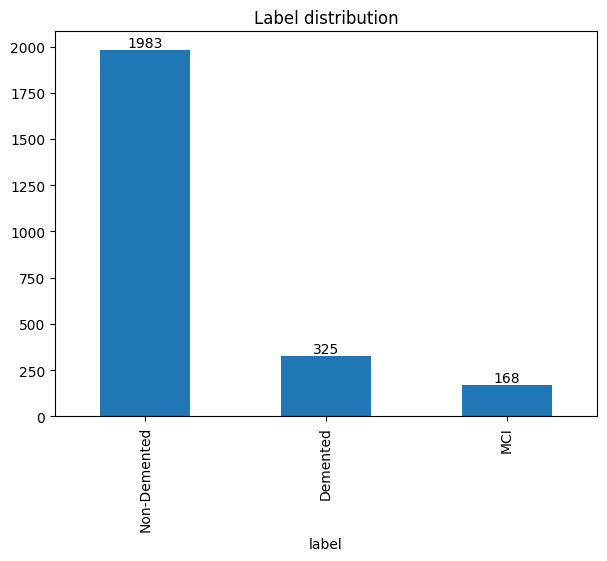

In [212]:
p.bar_plot(df_fsr['label'].value_counts(), 'Label distribution');

- Perform a final check

In [213]:
f = os.path.join('..', 'data', 'freesurfers')

left_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Left-Hippocampus.mgz')))
right_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Right-Hippocampus.mgz')))

l1 = [s.split("\\")[3] for s in left_hippo_files]
l2 = [s.split("\\")[3] for s in right_hippo_files]

print(f"The number of elements NOT in common is: {set.difference(set(l1), set(l2))}")

The number of elements NOT in common is: set()


- Get the final dataset as a csv

In [214]:
# Get rid of "noisy" patients aka patients not downloaded but present
# in the diagnosis csv
df_fsr.drop(index=df_fsr[~df_fsr['MR_session'].isin(l1)].index, inplace=True)

In [215]:
df_fsr.shape

(2475, 207)

In [216]:
df_fsr[[
    'Subject', 'TOTAL_HIPPOCAMPUS_VOLUME', 'Left-Hippocampus_volume', 
    'lh_parahippocampal_thickness', 'lh_parahippocampal_volume', 'rh_parahippocampal_volume',
    'rh_parahippocampal_thickness', 'Right-Hippocampus_volume', 'label'
]].to_csv('../data/csv/final_dataset.csv')